In [1]:
!nvidia-smi

Tue Oct  6 19:30:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/My Drive/CGIAR_Wheat_Growth_Stage_Challenge/zindi-cgiar.zip' images.zip # You may have them stored in a folder, in which case modify the path.

In [4]:
# Now we can unzip:
!unzip -q images.zip

# **Setup**

In [5]:
import numpy as np
import torch
import random
import os
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [6]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai

     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 194kB 3.8MB/s 


In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

In [8]:
# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina' 

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

# **Exploring**

In [11]:
# Load and view the data
train = pd.read_csv('Train.csv')
print(train.shape)
train.head(10)

(10695, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1
5,A60rOyP9,1,1
6,TnVJ3pgC,6,1
7,sYLqmiXV,3,2
8,Q5iyu8IP,7,1
9,s2X0it4L,1,1


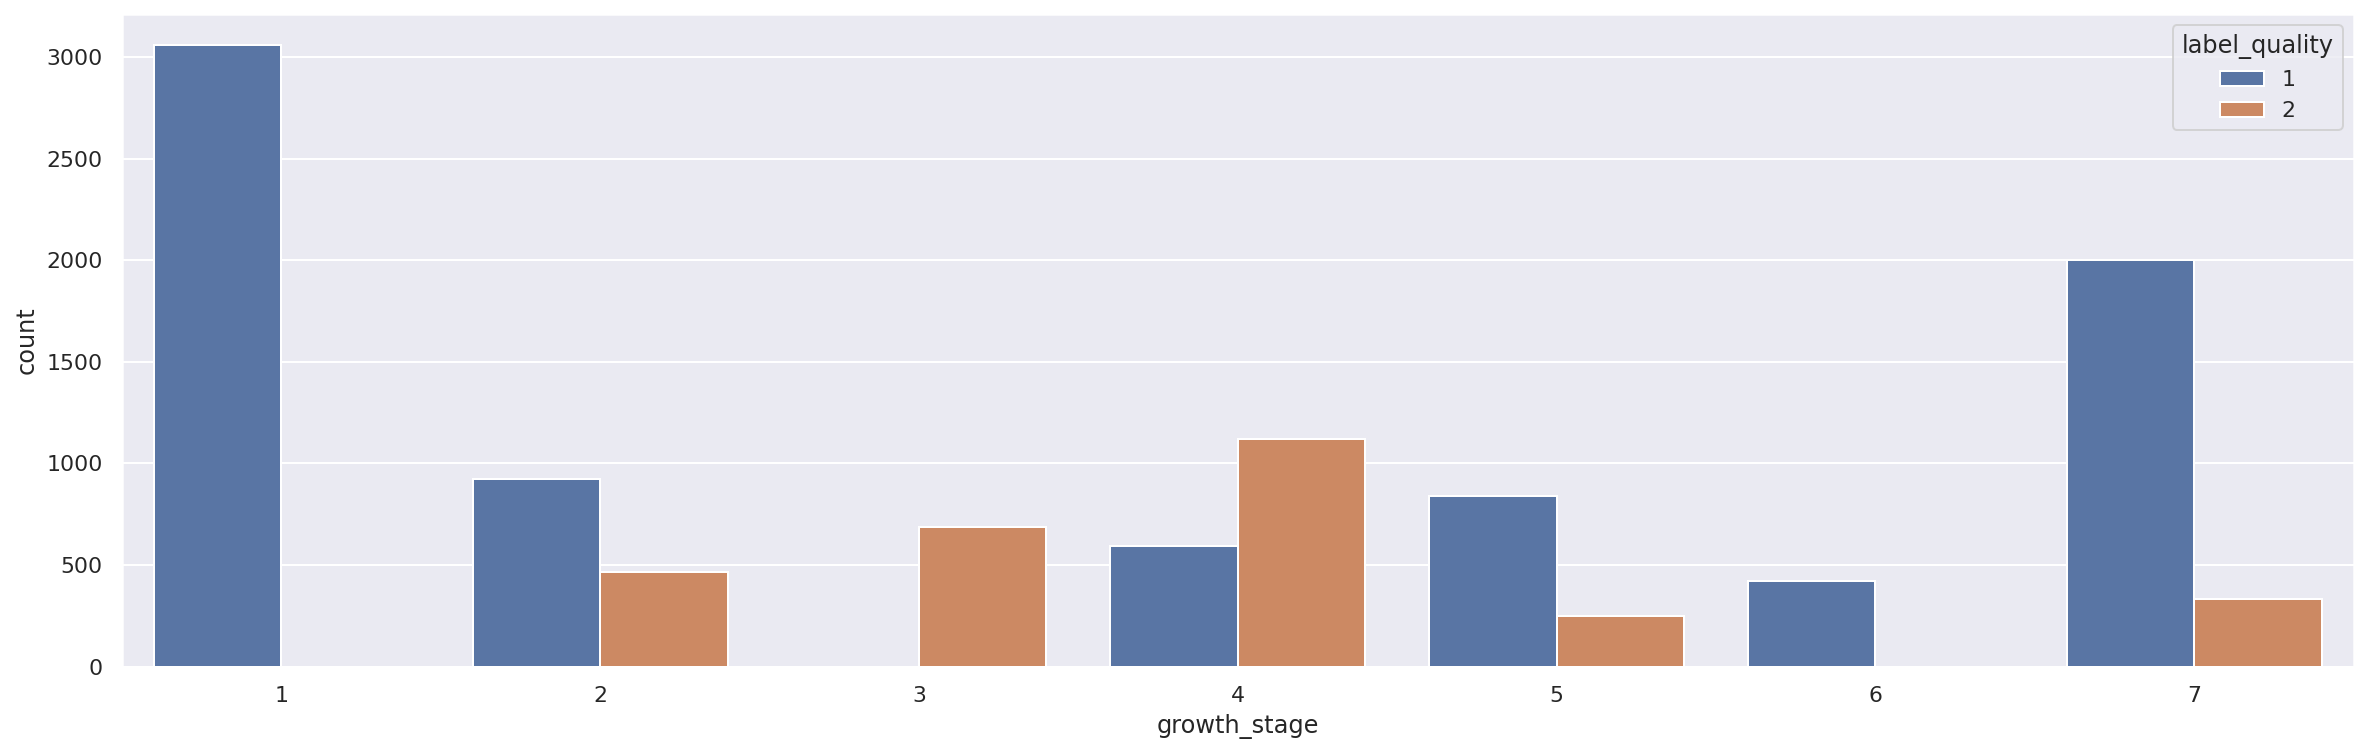

In [12]:
_, axes = plt.subplots(1, 1, sharey=True, figsize=(20, 6))
#plt.figure(figsize=(45,6))
sns.countplot(x='growth_stage', hue='label_quality', data=train );

# **StraightFOLD**

In [13]:
import random
import numpy as np
import gc
SEED_VAL  = 152
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED):
  random.seed(SEED_VAL)
  np.random.seed(SEED_VAL)
  torch.manual_seed(SEED_VAL)
  torch.cuda.manual_seed_all(SEED_VAL)
  os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [14]:
from sklearn.model_selection import StratifiedKFold

NAME = 'densenet201'
EPOCHS = 10
TRAIN_BATH_SIZE = 8
image_size = (256,400)
ss = pd.read_csv('SampleSubmission.csv')


skf = StratifiedKFold(n_splits=10,random_state=SEED_VAL)
all_rmse_scores = []
def run_folds():
  seed_all(SEED_VAL)
  test = pd.read_csv('SampleSubmission.csv')
  train = pd.read_csv('Train.csv')
  train = train.loc[train.label_quality == 2]
  
  DF = pd.DataFrame()
  for i,(train_index,val_index) in enumerate(skf.split(train,y=train.growth_stage)):
    print(f"#########################  Fold {i+1}/{skf.n_splits}  #########################")
    train_df , valid_df = train.iloc[train_index,:],train.iloc[val_index,:]
    
    # Create our dataloaders
    transforms = aug_transforms(max_rotate=15,max_zoom=2.0, max_lighting=0.4,
                              p_affine=1., p_lighting=1.)
    dls = ImageDataLoaders.from_df(train_df,valid_pct=0.1 ,path='Images/Images/', suff='.jpeg', 
                                  label_col='growth_stage', item_tfms=Resize(image_size),bs=TRAIN_BATH_SIZE,ds_tfms=transforms,num_workers=1)
    # define - Learner
    learn = cnn_learner(dls, densenet201, metrics=error_rate)
    print("\n `\n Start Training ....")
    learn.fine_tune(EPOCHS)
    print("\n `\n Start Validating ....")
    vdl = learn.dls.test_dl(valid_df) # Make valid dataloader
    preds = learn.get_preds(dl=vdl) # Get model validation predictions
    valid_preds = (preds[0] * tensor([int(c) for c in learn.dls.vocab])).sum(dim=1)
    targets = np.array(valid_df.growth_stage.values)
    valid_rmse = np.sqrt(((valid_preds - targets) ** 2).mean())
    print(f'VALIDATION RMSE FOR FOLD : {i} ::: {valid_rmse}')
    print("\n `\n Start PREDICTING ....")

    ss = pd.read_csv('SampleSubmission.csv')
    tdl = learn.dls.test_dl(ss) # Make test dataloader
    preds = learn.get_preds(dl=tdl) # Get model predictions
    preds_test = (preds[0] * tensor([int(c) for c in learn.dls.vocab])).sum(dim=1)
    test[f'preds_FOLD_{i}'] = preds_test
    print(test.head())

    gc.collect()
   
  return test


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [15]:
import warnings
warnings.simplefilter('ignore')                                       
submission = run_folds()

#########################  Fold 1/10  #########################


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth




 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.247556,0.745256,0.233463,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.897276,0.656997,0.249027,01:46
1,0.892847,0.565023,0.186770,01:48
2,0.846118,0.552426,0.210117,01:49
3,0.714372,0.531878,0.194553,01:49
4,0.640442,0.543139,0.221790,01:49
5,0.607266,0.479148,0.163424,01:49
6,0.472751,0.488522,0.147860,01:49
7,0.367138,0.542274,0.171206,01:49
8,0.280345,0.462915,0.140078,01:49
9,0.261537,0.469787,0.147860,01:49



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 0 ::: 0.4129670190675719

 `
 Start PREDICTING ....


        UID  growth_stage  preds_FOLD_0
0  F3LbWkZq             0      4.784315
1  6P4wLVzI             0      4.019276
2  Tn6HIrdS             0      2.994526
3  EYM5R1TK             0      3.999968
4  fkcevlA0             0      4.688940
#########################  Fold 2/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.347299,0.858641,0.307393,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.915200,0.593480,0.202335,01:49
1,0.963558,0.649486,0.225681,01:49
2,0.859700,0.703585,0.276265,01:50
3,0.734127,0.510801,0.198444,01:49
4,0.623832,0.523550,0.202335,01:49
5,0.538254,0.480000,0.175097,01:49
6,0.462138,0.455076,0.182879,01:49
7,0.346468,0.477606,0.186770,01:49
8,0.289804,0.462963,0.186770,01:49
9,0.229832,0.490964,0.186770,01:49



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 1 ::: 0.4392205298966162

 `
 Start PREDICTING ....


        UID  growth_stage  preds_FOLD_0  preds_FOLD_1
0  F3LbWkZq             0      4.784315      4.240155
1  6P4wLVzI             0      4.019276      3.993330
2  Tn6HIrdS             0      2.994526      2.988388
3  EYM5R1TK             0      3.999968      3.996618
4  fkcevlA0             0      4.688940      4.888706
#########################  Fold 3/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.431500,0.778521,0.272374,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.878559,0.488522,0.198444,01:50
1,0.906617,0.589528,0.194553,01:49
2,0.867249,0.520675,0.206226,01:49
3,0.752665,0.567797,0.241245,01:49
4,0.684329,0.506054,0.202335,01:49
5,0.636277,0.450955,0.190661,01:49
6,0.449868,0.424186,0.186770,01:49
7,0.354694,0.428436,0.143969,01:49
8,0.274603,0.430139,0.143969,01:49
9,0.261901,0.404283,0.143969,01:49



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 2 ::: 0.4225010247994279

 `
 Start PREDICTING ....


        UID  growth_stage  preds_FOLD_0  preds_FOLD_1  preds_FOLD_2
0  F3LbWkZq             0      4.784315      4.240155      4.532924
1  6P4wLVzI             0      4.019276      3.993330      4.002102
2  Tn6HIrdS             0      2.994526      2.988388      2.967512
3  EYM5R1TK             0      3.999968      3.996618      4.001158
4  fkcevlA0             0      4.688940      4.888706      5.233644
#########################  Fold 4/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.317782,0.917176,0.303502,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.962694,0.639916,0.241245,01:50
1,0.959542,0.696552,0.276265,01:49
2,0.862427,0.657228,0.225681,01:49
3,0.723155,0.536869,0.229572,01:49
4,0.659391,0.559913,0.245136,01:49
5,0.537191,0.556144,0.237354,01:50
6,0.498733,0.551070,0.237354,01:49
7,0.338454,0.538543,0.194553,01:49
8,0.248562,0.506005,0.167315,01:49
9,0.227613,0.509806,0.190661,01:50



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 3 ::: 0.4777971147261509

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_2  preds_FOLD_3
0  F3LbWkZq             0  ...      4.532924      4.875077
1  6P4wLVzI             0  ...      4.002102      3.994986
2  Tn6HIrdS             0  ...      2.967512      2.989623
3  EYM5R1TK             0  ...      4.001158      4.000443
4  fkcevlA0             0  ...      5.233644      4.999037

[5 rows x 6 columns]
#########################  Fold 5/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.359050,0.965265,0.319066,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.971511,0.665127,0.241245,01:49
1,0.820731,0.896573,0.315175,01:50
2,0.873738,0.801224,0.276265,01:49
3,0.754237,0.673653,0.237354,01:49
4,0.699543,0.596685,0.229572,01:49
5,0.582304,0.606689,0.206226,01:49
6,0.441955,0.584968,0.214008,01:49
7,0.374723,0.553061,0.186770,01:49
8,0.246527,0.572191,0.202335,01:49
9,0.257439,0.551783,0.194553,01:49



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 4 ::: 0.4486336774194773

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_3  preds_FOLD_4
0  F3LbWkZq             0  ...      4.875077      5.105856
1  6P4wLVzI             0  ...      3.994986      3.997489
2  Tn6HIrdS             0  ...      2.989623      2.979573
3  EYM5R1TK             0  ...      4.000443      4.000209
4  fkcevlA0             0  ...      4.999037      5.094576

[5 rows x 7 columns]
#########################  Fold 6/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.367484,0.843963,0.291829,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.926426,0.491859,0.186770,01:49
1,0.844083,0.690570,0.249027,01:50
2,0.926878,0.506401,0.182879,01:49
3,0.727158,0.504463,0.198444,01:49
4,0.678003,0.581803,0.221790,01:49
5,0.587496,0.520132,0.190661,01:49
6,0.452941,0.462393,0.155642,01:49
7,0.322477,0.515542,0.182879,01:50
8,0.247089,0.452447,0.143969,01:50
9,0.214111,0.440464,0.155642,01:50



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 5 ::: 0.47154424596818423

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_4  preds_FOLD_5
0  F3LbWkZq             0  ...      5.105856      4.833244
1  6P4wLVzI             0  ...      3.997489      4.002416
2  Tn6HIrdS             0  ...      2.979573      2.971981
3  EYM5R1TK             0  ...      4.000209      4.006758
4  fkcevlA0             0  ...      5.094576      4.929085

[5 rows x 8 columns]
#########################  Fold 7/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.379821,0.959030,0.326848,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.841678,0.685498,0.225681,01:50
1,0.911035,0.950211,0.334630,01:50
2,0.815634,0.807188,0.264591,01:50
3,0.728686,0.688708,0.245136,01:50
4,0.689834,0.652209,0.229572,01:50
5,0.518657,0.627424,0.221790,01:50
6,0.449899,0.495236,0.186770,01:50
7,0.362164,0.496629,0.194553,01:50
8,0.286481,0.479154,0.171206,01:50
9,0.279488,0.491779,0.190661,01:50



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 6 ::: 0.4674996357476332

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_5  preds_FOLD_6
0  F3LbWkZq             0  ...      4.833244      4.122838
1  6P4wLVzI             0  ...      4.002416      3.997063
2  Tn6HIrdS             0  ...      2.971981      2.969942
3  EYM5R1TK             0  ...      4.006758      4.002001
4  fkcevlA0             0  ...      4.929085      4.670295

[5 rows x 9 columns]
#########################  Fold 8/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.290656,1.072369,0.319066,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.895205,0.571724,0.245136,01:50
1,0.883175,0.745641,0.307393,01:50
2,0.840271,0.506902,0.206226,01:50
3,0.755199,0.532573,0.214008,01:50
4,0.658920,0.546364,0.233463,01:50
5,0.548687,0.495302,0.221790,01:50
6,0.453555,0.519970,0.214008,01:50
7,0.369720,0.500913,0.186770,01:50
8,0.257026,0.432183,0.175097,01:50
9,0.267033,0.468817,0.198444,01:50



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 7 ::: 0.5570885934494358

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_6  preds_FOLD_7
0  F3LbWkZq             0  ...      4.122838      4.516388
1  6P4wLVzI             0  ...      3.997063      3.790640
2  Tn6HIrdS             0  ...      2.969942      2.977098
3  EYM5R1TK             0  ...      4.002001      4.002215
4  fkcevlA0             0  ...      4.670295      5.340066

[5 rows x 10 columns]
#########################  Fold 9/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.386689,0.942322,0.276265,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.981782,0.609536,0.221790,01:50
1,1.086925,0.640707,0.241245,01:50
2,0.790970,0.605724,0.217899,01:50
3,0.789652,0.714779,0.249027,01:50
4,0.675977,0.492278,0.194553,01:50
5,0.542449,0.501482,0.190661,01:50
6,0.436486,0.414307,0.151751,01:50
7,0.322636,0.383216,0.151751,01:50
8,0.272148,0.391660,0.155642,01:50
9,0.226473,0.387355,0.159533,01:50



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 8 ::: 0.5461720322582748

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_7  preds_FOLD_8
0  F3LbWkZq             0  ...      4.516388      4.411398
1  6P4wLVzI             0  ...      3.790640      3.989935
2  Tn6HIrdS             0  ...      2.977098      2.904953
3  EYM5R1TK             0  ...      4.002215      3.996132
4  fkcevlA0             0  ...      5.340066      5.590724

[5 rows x 11 columns]
#########################  Fold 10/10  #########################

 `
 Start Training ....


epoch,train_loss,valid_loss,error_rate,time
0,1.296401,0.977457,0.295720,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.848762,0.796042,0.264591,01:50
1,0.919077,0.711049,0.307393,01:50
2,0.820296,0.618430,0.237354,01:50
3,0.684609,0.633923,0.245136,01:50
4,0.640363,0.627702,0.206226,01:50
5,0.576997,0.630845,0.229572,01:50
6,0.471374,0.609263,0.221790,01:50
7,0.292624,0.605144,0.198444,01:50
8,0.319851,0.552158,0.175097,01:50
9,0.221377,0.573271,0.178988,01:50



 `
 Start Validating ....


VALIDATION RMSE FOR FOLD : 9 ::: 0.5261931432685629

 `
 Start PREDICTING ....


        UID  growth_stage  ...  preds_FOLD_8  preds_FOLD_9
0  F3LbWkZq             0  ...      4.411398      4.767238
1  6P4wLVzI             0  ...      3.989935      3.982632
2  Tn6HIrdS             0  ...      2.904953      2.997719
3  EYM5R1TK             0  ...      3.996132      4.001278
4  fkcevlA0             0  ...      5.590724      5.059136

[5 rows x 12 columns]


In [18]:
ss = pd.read_csv('SampleSubmission.csv')
ss['growth_stage'] = submission.iloc[:,2:].mean(axis=1)

In [19]:
ss.head()

,UID,growth_stage
0,F3LbWkZq,4.618943
1,6P4wLVzI,3.976987
2,Tn6HIrdS,2.974131
3,EYM5R1TK,4.000678
4,fkcevlA0,5.049421


In [20]:
ss.to_csv('densenet201_classif_FastaAI.csv',index=False)